In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from openpyxl import Workbook,load_workbook
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

day_info = '_13124_d14'
res_path = 'xxxx'
load_path = 'xxxx'

res_path: F:/THU/post_craniotomy/results/13124/
load_path: F:/THU/post_craniotomy/data/13124/reco_13124_d14_220140/
trigger_path: F:/THU/post_craniotomy/data/trigger/13124/
allen_path: F:/THU/anesthesia/data/allen_brain_map/
stimu_path: F:/THU/post_craniotomy/data/stimuli/


# Load data

whole_trace_ori: <class 'pandas.core.frame.DataFrame'> (11988, 5022)


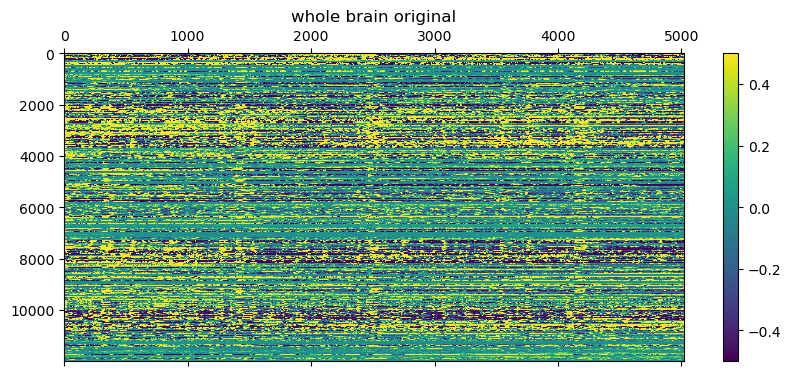

In [2]:
# load calcium data

whole_trace_ori = pd.read_csv(load_path + "trace" + day_info + ".csv", header = None)
print("whole_trace_ori:", type(whole_trace_ori), whole_trace_ori.shape)
whole_trace_ori = whole_trace_ori.values

fig,ax = plt.subplots(figsize=(10,4), dpi=100, facecolor="w")
caxes = ax.matshow(whole_trace_ori, vmin = -0.5, vmax = 0.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain original")
plt.show()

whole_center: <class 'pandas.core.frame.DataFrame'> (11988, 3)
neuron_x: <class 'numpy.ndarray'> (11988,) [ 95.    64.    89.5  239.5  217.86]
neuron_y: <class 'numpy.ndarray'> (11988,) [88.5   89.333 72.5   54.5   60.143]
neuron_z: <class 'numpy.ndarray'> (11988,) [30.  32.  31.5 37.5 34. ]


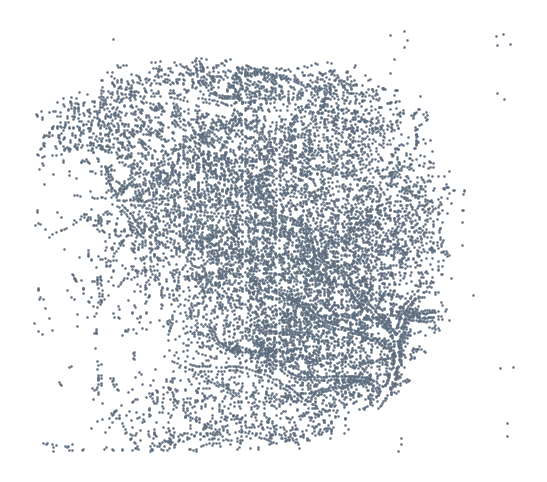

In [3]:
# load neuronal positions

whole_center = pd.read_csv(load_path + "pos" + day_info + ".csv", names = ["x", "y", "z"])
print("whole_center:", type(whole_center), whole_center.shape)
whole_center = whole_center.values

neuron_x = whole_center[:, 0].reshape(len(whole_center))
print("neuron_x:", type(neuron_x), neuron_x.shape, neuron_x[:5])

neuron_y = whole_center[:, 1].reshape(len(whole_center))
print("neuron_y:", type(neuron_y), neuron_y.shape, neuron_y[:5])

neuron_z = whole_center[:, 2].reshape(len(whole_center))
print("neuron_z:", type(neuron_z), neuron_z.shape, neuron_z[:5])

'''
plot 
'''
fig, ax = plt.subplots(figsize = (6.8, 6), dpi= 100,facecolor="w")
plt.scatter(neuron_x, neuron_y, s = 1, c = "#5d6d7e", alpha = 0.8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.show()

# 01 All neurons

In [5]:
''' number & intensity '''

intensity_avg = round(np.mean(whole_trace_ori),3)
number_all = len(whole_trace_ori)
save_data = {"intensity_avg": intensity_avg, "number_all": number_all}
print(save_data)

np.save(res_path + "res_global_number_intensity" + day_info + "_dict.npy", save_data)

{'intensity_avg': 0.185, 'number_all': 11988}


# 02 Responsive neurons

## response number

In [12]:
n_stimu = 3

angle_neuron_dict, angle_neuron_all_dict = {}, {}
for angle in [0, 45, 90, 135]:
    neuron_num, neuron_all_num = [], []
    for stimu in range(n_stimu):  
        select_neuron_ids = np.load(res_path + "neurons/overlap_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
        neuron_num.append(len(select_neuron_ids))
        select_neuron_ids = np.load(res_path + "neurons/overlap_all_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
        neuron_all_num.append(len(select_neuron_ids))
    angle_neuron_dict[angle] = neuron_num
    angle_neuron_all_dict[angle] = neuron_all_num
print("angle_neuron_dict:", len(angle_neuron_dict), angle_neuron_dict)
print("angle_neuron_all_dict:", len(angle_neuron_all_dict), angle_neuron_all_dict)

np.save(res_path + "res_response_number_overlap_angles_sep" + day_info + "_dict.npy", angle_neuron_dict)
np.save(res_path + "res_response_number_overlap_all_angles_sep" + day_info + "_dict.npy", angle_neuron_all_dict)

angle_neuron_dict: 4 {0: [458, 331, 272], 45: [277, 266, 298], 90: [278, 379, 299], 135: [352, 403, 289]}
angle_neuron_all_dict: 4 {0: [7570, 7330, 7357], 45: [7239, 7036, 7074], 90: [7401, 7408, 7357], 135: [7315, 7678, 7418]}
all_angle_neuron_list: 3 [1130, 1149, 986]
all_angle_neuron_ids: 3


## response map

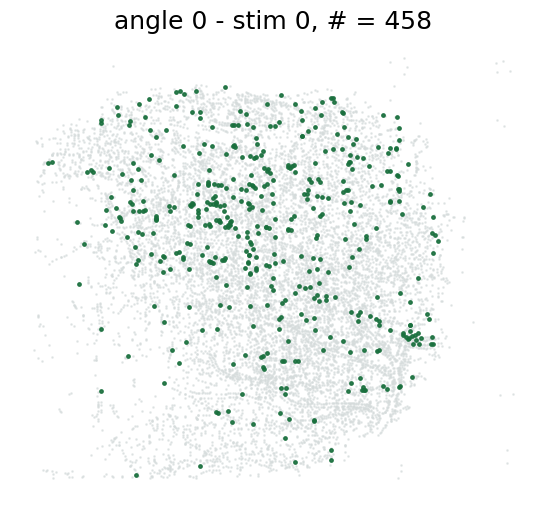

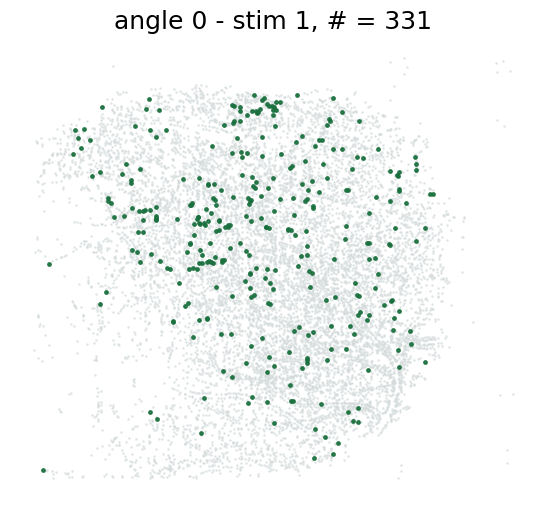

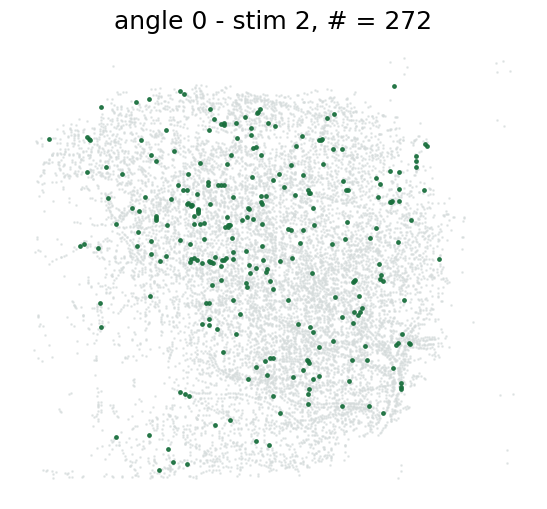

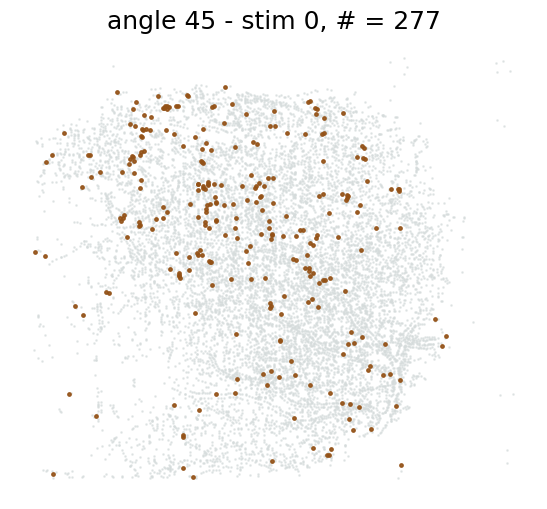

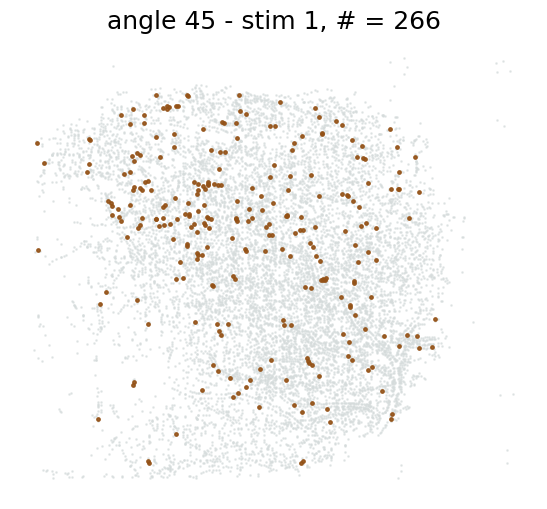

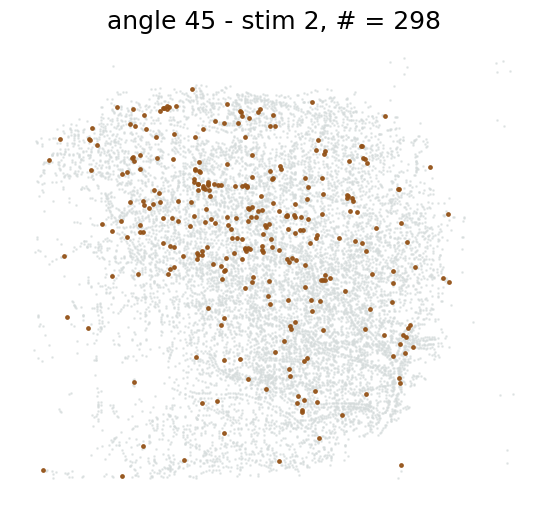

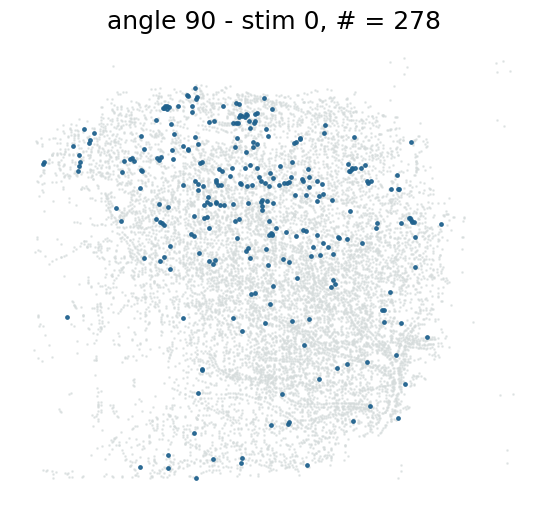

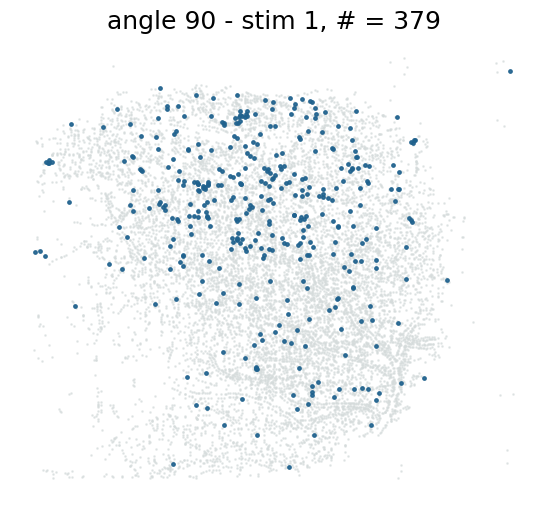

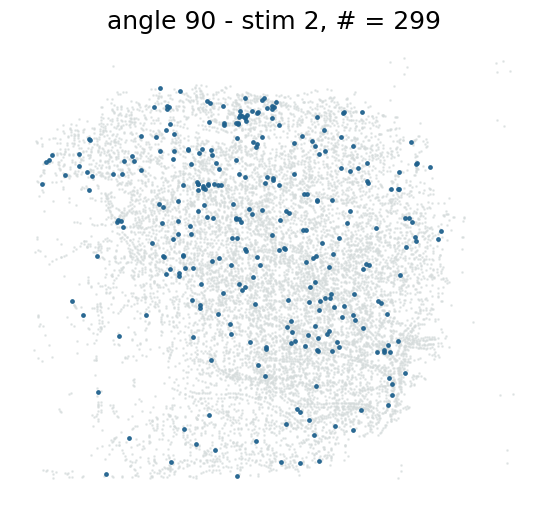

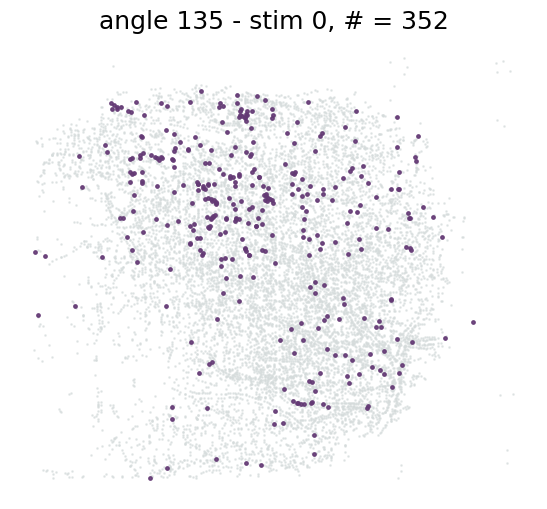

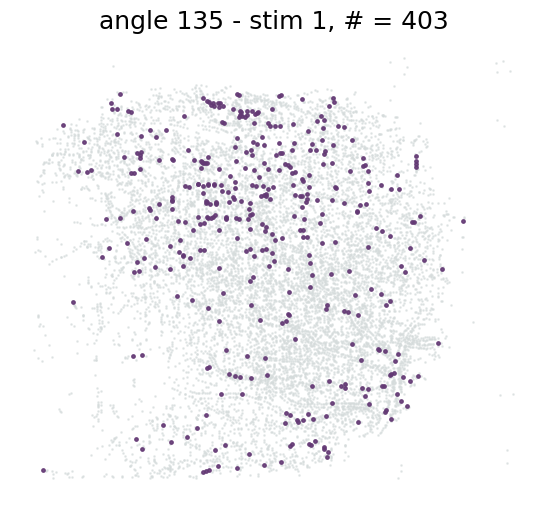

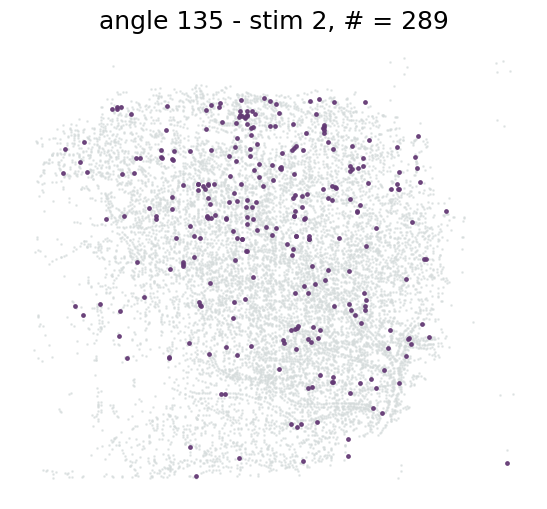

neuron_ids_dict: 4 neuron_pos_dict: 4


In [15]:
color_dict = {0:"#196F3D", 45:"#935116", 90:"#1F618D", 135:"#633974"}

neuron_ids_dict, neuron_pos_dict = {}, {}
for angle in [0, 45, 90, 135]:
    neuron_ids_dict[angle] = []
    neuron_pos_dict[angle] = []
    
for angle in [0, 45, 90, 135]:
    neuron_ids = []
    for stimu in range(n_stimu):  
        neuron_ids = np.load(res_path + "neurons/overlap_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
        neuron_ids_dict[angle].append(neuron_ids)
        neuron_pos_dict[angle].append([(neuron_x[i], neuron_y[i], neuron_z[i])for i in neuron_ids])

        # plot
        select_neuron_x, select_neuron_y = neuron_x[neuron_ids], neuron_y[neuron_ids]
        non_select_data_ids = [i for i in range(len(whole_trace_ori)) if i not in neuron_ids]
        non_neuron_x, non_neuron_y = neuron_x[non_select_data_ids], neuron_y[non_select_data_ids]
        fig, ax = plt.subplots(figsize = (6.8, 6), dpi= 100,facecolor="w")
        plt.scatter(non_neuron_x, non_neuron_y, s = 0.8, c = "#D5DBDB", alpha = 0.6)
        plt.scatter(select_neuron_x, select_neuron_y, s = 6, c = color_dict[angle], alpha = 0.9)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.title("angle " + str(angle) + " - stim " + str(stimu) + ", # = " + str(len(neuron_ids)), fontsize = 18)
        plt.xticks([])
        plt.yticks([])
        plt.show()
print("neuron_ids_dict:", len(neuron_ids_dict), "neuron_pos_dict:", len(neuron_pos_dict))      

np.save(res_path + "res_response_ids_overlap_angles_sep" + day_info + "_dict.npy", neuron_ids_dict)
np.save(res_path + "res_response_pos_overlap_angles_sep" + day_info + "_dict.npy", neuron_pos_dict)


# 03 Functional connectivity

angle0_start_list: (24,) [ 969 1111 1433 1521 1567 1613 1759 1855 2474 2616]
angle45_start_list: (24,) [ 697  739  785  877 1253 1299 1391 1709 2202 2244]
angle90_start_list: (24,) [ 555  651  831 1019 1061 1345 1809 1901 2060 2156]
angle135_start_list: (24,) [ 509  605  923 1161 1211 1479 1663 1943 2014 2110]
neuron_ids_list: 876
stable_neurons_trace: (876, 672)
similarity: (876, 876)


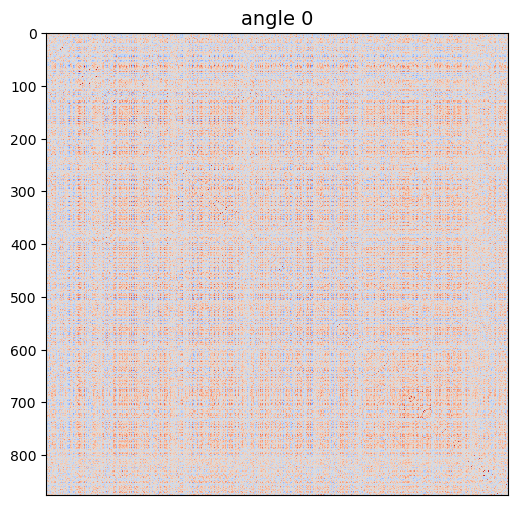

neuron_ids_list: 671
stable_neurons_trace: (671, 672)
similarity: (671, 671)


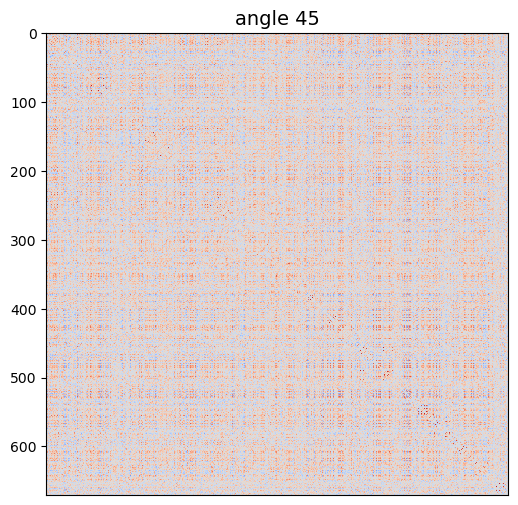

neuron_ids_list: 761
stable_neurons_trace: (761, 672)
similarity: (761, 761)


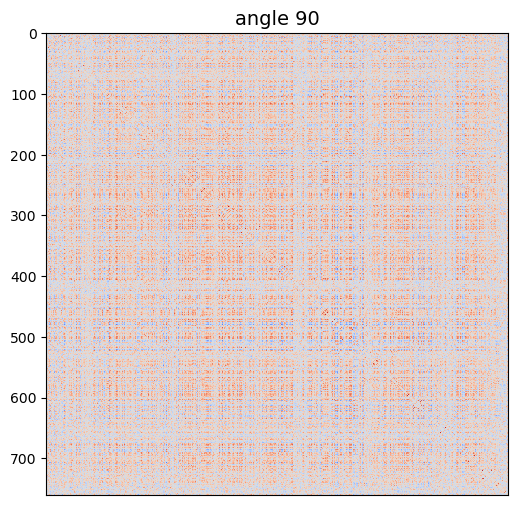

neuron_ids_list: 831
stable_neurons_trace: (831, 672)
similarity: (831, 831)


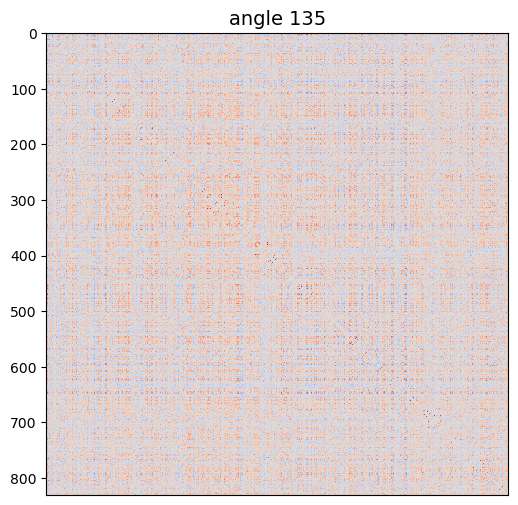

similarity_dict: 4 neuron_ids_dict: 4 neuron_trace_dict: 4


In [21]:
''' correlation matrix '''

angle0_start_list = np.load(res_path + "angle0_calc_start_whole_stages" + day_info + ".npy").flatten()
angle45_start_list = np.load(res_path + "angle45_calc_start_whole_stages" + day_info + ".npy").flatten()
angle90_start_list = np.load(res_path + "angle90_calc_start_whole_stages" + day_info + ".npy").flatten()
angle135_start_list = np.load(res_path + "angle135_calc_start_whole_stages" + day_info + ".npy").flatten()
print("angle0_start_list:", angle0_start_list.shape, angle0_start_list[:10])
print("angle45_start_list:", angle45_start_list.shape, angle45_start_list[:10])
print("angle90_start_list:", angle90_start_list.shape, angle90_start_list[:10])
print("angle135_start_list:", angle135_start_list.shape, angle135_start_list[:10])
angle_dict = {0:angle0_start_list, 45:angle45_start_list, 90:angle90_start_list, 135:angle135_start_list}

duration = 8
duration_corr = duration * 3

similarity_dict, neuron_ids_dict, neuron_trace_dict = {}, {}, {}
for angle in [0,45,90,135]:
    # neurons
    neuron_ids_list = []
    for stimu in range(n_stimu):  
        neuron_ids = np.load(res_path + "neurons/overlap_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
        neuron_ids_list.extend(neuron_ids)
    neuron_ids_list = list(set(neuron_ids_list))
    print("neuron_ids_list:", len(neuron_ids_list))
    
    # trace concat
    stable_neurons_trace = []
    stimu_start, stimu_end = 0, n_stimu * 8
    for time in angle_dict[angle][stimu_start : stimu_end]:
        time_trace = whole_trace_ori[neuron_ids_list, time - 4 : time + duration_corr]
        if len(stable_neurons_trace) == 0:
            stable_neurons_trace = time_trace
        else:
            stable_neurons_trace = np.concatenate((stable_neurons_trace, time_trace), axis = 1)
    print("stable_neurons_trace:", np.array(stable_neurons_trace).shape)
    
    # corelation matrix
    n_neuron = len(stable_neurons_trace)
    similarity = np.zeros((n_neuron, n_neuron))
    for i in range(n_neuron - 1):
        for j in range(i + 1, n_neuron):
            pearson = pearsonr(stable_neurons_trace[i], stable_neurons_trace[j])
            if not np.isnan(pearson[0]):# and pearson[1] < p_thre:
                similarity[i,j] = similarity[j,i] = pearson[0]
    print("similarity:", similarity.shape)
    
    # plot
    fig,ax = plt.subplots(figsize=(6,6),dpi=100,facecolor="w")
    ax = plt.subplot(1,1,1)
    caxes = ax.matshow(similarity, interpolation ='nearest',cmap = 'coolwarm', vmax = 1, vmin = -1)
    plt.title("angle " + str(angle), fontsize = 14)
    plt.xticks([])
    plt.show()
    
    similarity_dict[angle] = similarity
    neuron_ids_dict[angle] = neuron_ids_list
    neuron_trace_dict[angle] = stable_neurons_trace
    
print("similarity_dict:", len(similarity_dict), "neuron_ids_dict:", len(neuron_ids_dict), "neuron_trace_dict:", len(neuron_trace_dict))   
np.save(res_path + "res_angle_stable_neurons_corr_matrix" + day_info + "_dict.npy", similarity_dict)
np.save(res_path + "res_angle_stable_neurons_corr_neuron_ids" + day_info + "_dict.npy", neuron_ids_dict)
np.save(res_path + "res_angle_stable_neurons_corr_neuron_trace" + day_info + "_dict.npy", neuron_trace_dict)



In [7]:
''' correlation statistics '''

similarity_dict = np.load(res_path + "res_angle_stable_neurons_corr_matrix" + day_info + "_dict.npy", allow_pickle = True).item()
corr_thre = 0.5

corr_avg, corr_large_ratio, corr_pos_ratio = [], [], []
corr_set_dict, corr_set_pos_dict = {}, {}
for angle in [0,45,90,135]:
    similarity = similarity_dict[angle]
    
    # stats
    similarity_fla = similarity.flatten()
    sim_list_positive = [i for i in similarity_fla if i > 0]
    corr_avg.append(round(np.mean(sim_list_positive), 3))
    corr_pos_ratio.append(round(len(sim_list_positive) / len(similarity_fla), 3))
    corr_large = [i for i in similarity_fla if i >= corr_thre]
    corr_large_ratio.append(round(len(corr_large) / len(sim_list_positive), 3))
    
    # dist
    corr_set_list, corr_set_pos_list = [], []
    n_neuron = len(similarity)
    for i in range(n_neuron - 1):
        for j in range(i + 1, n_neuron):
            corr_set_list.append(similarity[i,j])
            if similarity[i,j] > 0:
                corr_set_pos_list.append(similarity[i,j])
    corr_set_dict[angle] = corr_set_list
    corr_set_pos_dict[angle] = corr_set_pos_list
    
print("corr_avg:", corr_avg)  
print("corr_pos_ratio:", corr_pos_ratio)  
print("corr_large_ratio:", corr_large_ratio)  
print("corr_set_dict:", len(corr_set_dict), "corr_set_pos_dict:", len(corr_set_pos_dict))  

data = {"corr_avg": corr_avg, "corr_pos_ratio": corr_pos_ratio, "corr_large_ratio": corr_large_ratio}
np.save(res_path + "res_angle_stable_neurons_corr_matrix_stat" + day_info + "_dict.npy", data)
np.save(res_path + "res_angle_stable_neurons_corr_list" + day_info + "_dict.npy", corr_set_dict)
np.save(res_path + "res_angle_stable_neurons_corr_pos_list" + day_info + "_dict.npy", corr_set_pos_dict)


corr_avg: [0.197, 0.174, 0.196, 0.173]
corr_pos_ratio: [0.606, 0.592, 0.627, 0.599]
corr_large_ratio: [0.042, 0.024, 0.041, 0.019]
corr_set_dict: 4 corr_set_pos_dict: 4


D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


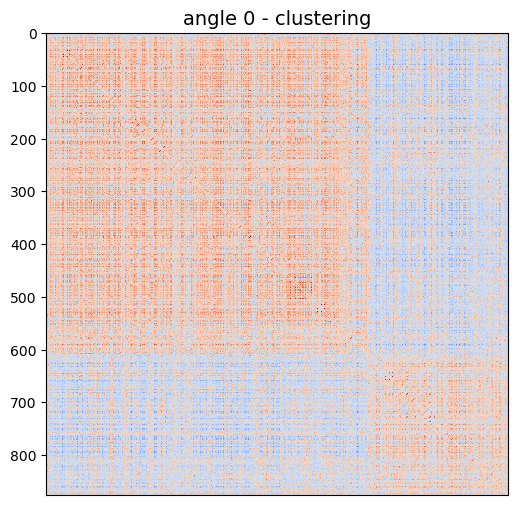

D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


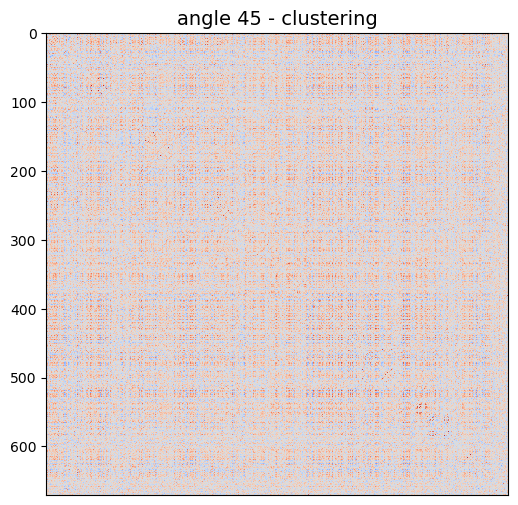

D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


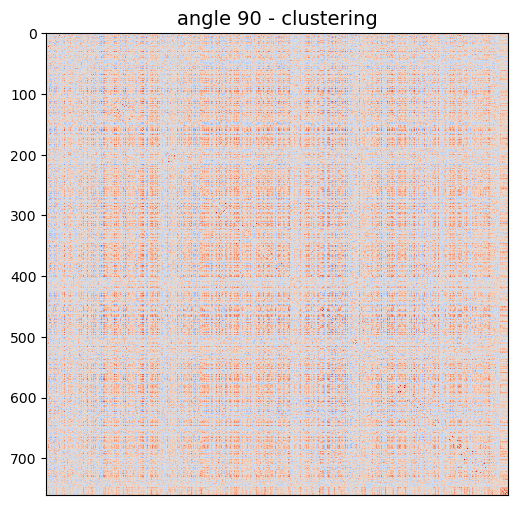

D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


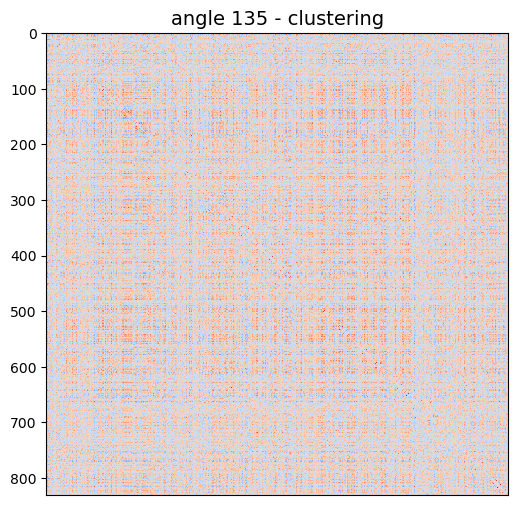

ratio_list: 4 [3.092, 9.736, 1.2, 8.236]
delta_list: 4 [0.204, 0.233, 0.148, 0.176]


In [11]:
''' modularity '''

import networkx as nx
from networkx.algorithms import community

k = 2
threshold = 0.5
similarity_dict = np.load(res_path + "res_angle_stable_neurons_corr_matrix" + day_info + "_dict.npy", allow_pickle = True).item()
neuron_ids_dict = np.load(res_path + "res_angle_stable_neurons_corr_neuron_ids" + day_info + "_dict.npy", allow_pickle = True).item()

delta_list, ratio_list = [], []
for angle in [0,45,90,135]:
    similarity = similarity_dict[angle]
    select_ids = neuron_ids_dict[angle]

    ''' clustering '''
    spectral_cluster = SpectralClustering(n_clusters = k) #KMeans(n_clusters = k)
    clusters = spectral_cluster.fit_predict(similarity)
    clusters = [i + 1 for i in clusters]

    # sorted ids
    hierarchy_idx_fla = []
    hie_cnt = 0
    for index_id in range(1,k + 1):
        index = [i for i,j in enumerate(clusters) if j == index_id]
        hierarchy_idx_fla.extend(index)
        if index_id == 1:
            hie_cnt = len(index)

    # calculate cluster correlation
    similarity_hie = np.zeros(similarity.shape)
    n_neuron = len(select_ids)
    for i in range(n_neuron - 1):
        for j in range(i + 1, n_neuron):   
            x, y = hierarchy_idx_fla[i],hierarchy_idx_fla[j]
            similarity_hie[i,j] = similarity_hie[j,i] = similarity[x,y]
    
    # plot
    fig,ax = plt.subplots(figsize=(10,6),dpi=100,facecolor="w")
    ax = plt.subplot(1,1,1)
    caxes = ax.matshow(similarity_hie, interpolation ='nearest',cmap = 'coolwarm', vmax = 1, vmin = -1)
    plt.title("angle " + str(angle) + " - clustering", fontsize = 14)
    plt.xticks([])
    plt.show()
    
    # w / b ratio
    within_avg = (np.mean(similarity_hie[:hie_cnt, :hie_cnt]) + np.mean(similarity_hie[hie_cnt:, hie_cnt:])) / 2
    between_avg = (np.mean(similarity_hie[:hie_cnt, hie_cnt:]) + np.mean(similarity_hie[hie_cnt:, :hie_cnt])) / 2
    ratio = (within_avg - between_avg) / abs(between_avg)
    delta = within_avg - between_avg
    ratio_list.append(round(ratio, 3))
    delta_list.append(round(delta, 3))

print("ratio_list:", len(ratio_list), ratio_list)
np.save(res_path + "res_stable_neurons_corr_cluster_wb_ratio" + day_info + "_list.npy", ratio_list)
print("delta_list:", len(delta_list), delta_list)
np.save(res_path + "res_stable_neurons_corr_cluster_wb_delta" + day_info + "_list.npy", delta_list)    

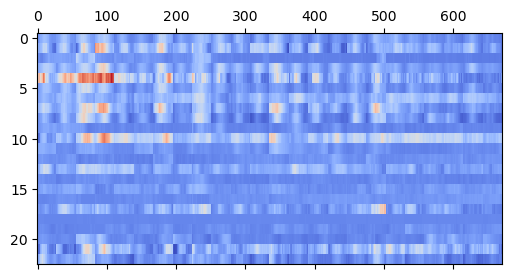

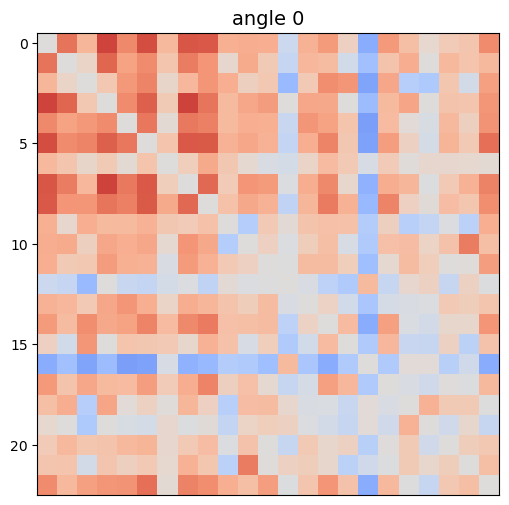

# original edges, preserved edges: 264.5 39


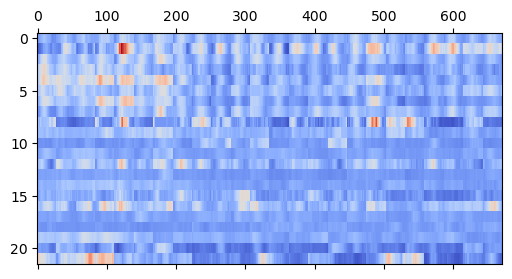

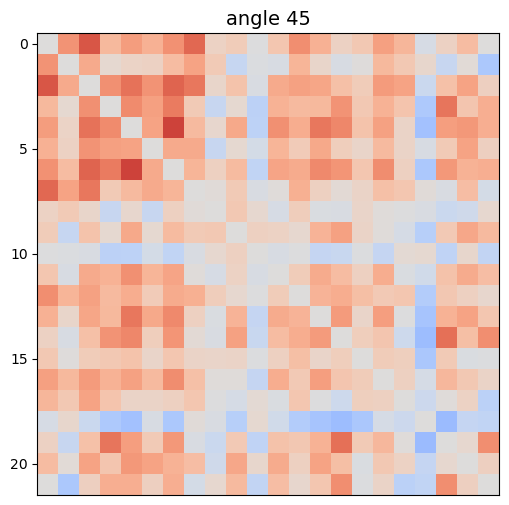

# original edges, preserved edges: 242.0 26


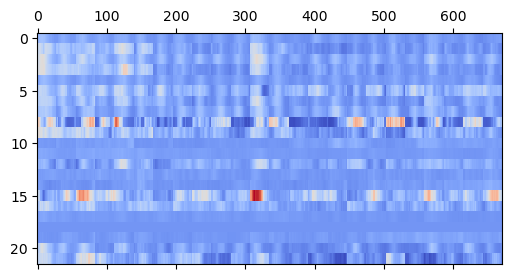

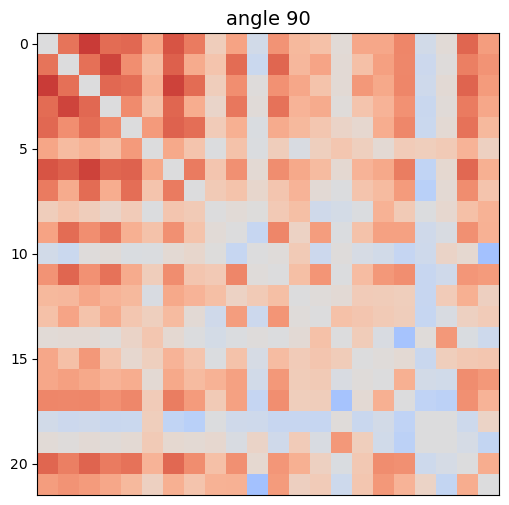

# original edges, preserved edges: 242.0 53


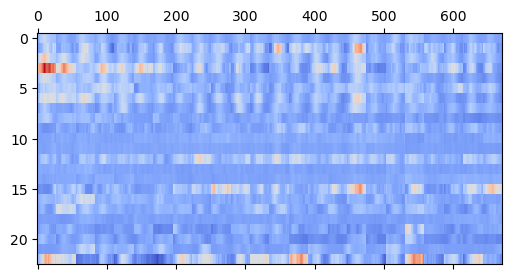

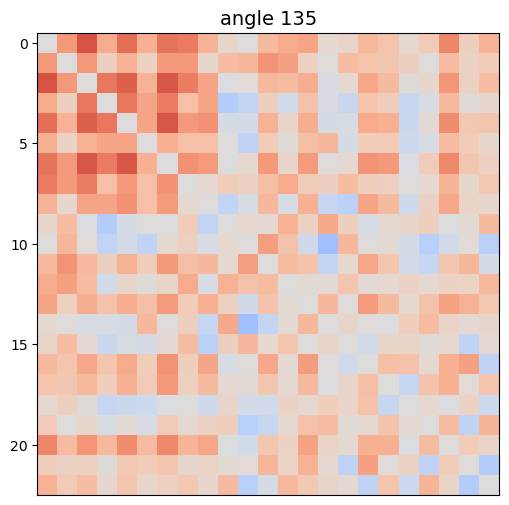

# original edges, preserved edges: 264.5 21


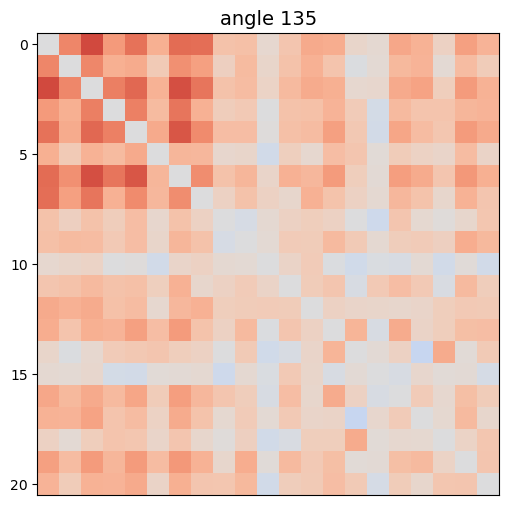

In [13]:
''' region correlation '''

angle0_start_list = np.load(res_path + "angle0_calc_start_whole_stages" + day_info + ".npy").flatten()
angle45_start_list = np.load(res_path + "angle45_calc_start_whole_stages" + day_info + ".npy").flatten()
angle90_start_list = np.load(res_path + "angle90_calc_start_whole_stages" + day_info + ".npy").flatten()
angle135_start_list = np.load(res_path + "angle135_calc_start_whole_stages" + day_info + ".npy").flatten()
angle_dict = {0:angle0_start_list, 45:angle45_start_list, 90:angle90_start_list, 135:angle135_start_list}

n_stimu = 3
duration = 8
duration_corr = duration * 3
threshold = 0.5

similarity_dict, region_acs_dict = {}, {}
node_degrees_dict, degree_centrality_dict, closeness_centrality_dict = {}, {}, {}
acs_exist_all = []
modularity_all = []
for angle in [0,45,90,135]:
    # neurons
    neuron_ids_list = []
    for stimu in range(n_stimu):  
        neuron_ids = np.load(res_path + "neurons/overlap_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
        neuron_ids_list.extend(neuron_ids)
    neuron_ids_list = list(set(neuron_ids_list))
    
    # trace concat
    stable_neurons_trace = []
    stimu_start, stimu_end = 0, n_stimu * 8
    for time in angle_dict[angle][stimu_start : stimu_end]:
        time_trace = whole_trace_ori[neuron_ids_list, time - 4 : time + duration_corr]
        if len(stable_neurons_trace) == 0:
            stable_neurons_trace = time_trace
        else:
            stable_neurons_trace = np.concatenate((stable_neurons_trace, time_trace), axis = 1)
    stable_neurons_trace = np.array(stable_neurons_trace)
    
    # mapping
    acs = pd.read_csv(load_path + '/acs.csv')
    acs = list(acs)
    acs = [i.split(".")[0] for i in acs]

    active_acs = list(np.array(acs)[neuron_ids_list])
    active_acs_set = list(set(active_acs))
    active_acs_set.sort()
    active_acs_set.reverse()
    region_trace = []
    for acs_i in active_acs_set:
        idx = [i for i in range(len(active_acs)) if active_acs[i] == acs_i]
        trace_i = np.mean(stable_neurons_trace[idx], axis = 0)
        region_trace.append(trace_i)
    fig,ax = plt.subplots(figsize=(6,3),dpi=100,facecolor="w")
    ax = plt.subplot(1,1,1)
    caxes = ax.matshow(region_trace, interpolation ='nearest',cmap = 'coolwarm', aspect = "auto")
    plt.show()
            
    # corelation matrix
    n_neuron = len(region_trace)
    similarity = np.zeros((n_neuron, n_neuron))
    for i in range(n_neuron - 1):
        for j in range(i + 1, n_neuron):
            pearson = pearsonr(region_trace[i], region_trace[j])
            if not np.isnan(pearson[0]):# and pearson[1] < p_thre:
                similarity[i,j] = similarity[j,i] = pearson[0]
    
    # plot
    fig,ax = plt.subplots(figsize=(6,6),dpi=100,facecolor="w")
    ax = plt.subplot(1,1,1)
    caxes = ax.matshow(similarity, interpolation ='nearest',cmap = 'coolwarm', vmax = 1, vmin = -1)
    plt.title("angle " + str(angle), fontsize = 14)
    plt.xticks([])
    plt.show()
    
    # network
    n_neurons = len(similarity)
    nodes = [i for i in range(n_neurons)]
    weighted_edges = [] 
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):
            x, y = nodes[i], nodes[j]
            v = similarity[i,j]
            if v < threshold:
                continue
            weighted_edges.append(np.array([x, y, np.round(v,4)]))
    print("# original edges, preserved edges:", len(similarity) ** 2 / 2, len(weighted_edges))

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    louvain_communities_comm = community.louvain_communities(G, weight='weight')  
    louvain_communities_mod = community.modularity(G, louvain_communities_comm)
    modularity_all.append(round(louvain_communities_mod, 3))
    
    node_degrees = [round(i[1],3) for i in nx.degree(G,weight="weight")]
    degree_centrality = [round(i,3) for i in nx.degree_centrality(G).values()]
    closeness_centrality = [round(i,3) for i in nx.closeness_centrality(G).values()]
    for i in range(len(active_acs_set)):
        acs_i = active_acs_set[i]
        if acs_i in node_degrees_dict:
            node_degrees_dict[acs_i].append(node_degrees[i] / len(nodes))
        else:
            node_degrees_dict[acs_i] = [node_degrees[i] / len(nodes)]
            
        if acs_i in degree_centrality_dict:
            degree_centrality_dict[acs_i].append(degree_centrality[i])
        else:
            degree_centrality_dict[acs_i] = [degree_centrality[i]]
            
        if acs_i in closeness_centrality_dict:
            closeness_centrality_dict[acs_i].append(closeness_centrality[i])
        else:
            closeness_centrality_dict[acs_i] = [closeness_centrality[i]]
            
    # all
    similarity_dict[angle] = similarity
    region_acs_dict[angle] = active_acs_set
    acs_exist_all.append(active_acs_set)
    
np.save(res_path + "res_angle_region_corr_matrix" + day_info + "_dict.npy", similarity_dict)
np.save(res_path + "res_angle_region_corr_acs" + day_info + "_dict.npy", region_acs_dict)
np.save(res_path + "res_angle_region_corr_modularity" + day_info + "_list.npy", modularity_all)
np.save(res_path + "res_angle_region_corr_node_degree" + day_info + "_dict.npy", node_degrees_dict)
np.save(res_path + "res_angle_region_corr_degree_central" + day_info + "_dict.npy", degree_centrality_dict)
np.save(res_path + "res_angle_region_corr_closeness_central" + day_info + "_dict.npy", closeness_centrality_dict)


''' avgerage '''
acs_all_overlap = []
for i in acs_exist_all[0]:
    keep = True
    for j in range(1, len(acs_exist_all)):
        if i not in acs_exist_all[j]:
            keep = False
            break
    if keep:
        acs_all_overlap.append(i)
acs_all_overlap.sort()
acs_all_overlap.reverse()

n_neuron = len(acs_all_overlap)
similarity = np.zeros((n_neuron, n_neuron))
for i in range(n_neuron - 1):
    for j in range(i + 1, n_neuron):
        acs_i, acs_j = acs_all_overlap[i], acs_all_overlap[j]
        value = 0
        for angle in [0,45,90,135]:
            active_acs_set = region_acs_dict[angle]
            idx_i, idx_j = active_acs_set.index(acs_i), active_acs_set.index(acs_j)
            value += similarity_dict[angle][idx_i, idx_j]
        similarity[i,j] = similarity[j,i] = round(value / 4, 3)
    
# plot
fig,ax = plt.subplots(figsize=(6,6),dpi=100,facecolor="w")
ax = plt.subplot(1,1,1)
caxes = ax.matshow(similarity, interpolation ='nearest',cmap = 'coolwarm', vmax = 1, vmin = -1)
plt.title("angle " + str(angle), fontsize = 14)
plt.xticks([])
plt.show()

np.save(res_path + "res_angle_region_corr_matrix_avg" + day_info + ".npy", similarity)
np.save(res_path + "res_angle_region_corr_acs_avg" + day_info + ".npy", acs_all_overlap)